## SVM on BOW features
SIFT Bag Of Words features

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray();

import sys
import numpy as np
sys.path.append('../scripts')
import datasets

#### Cluster definition and Initialization

In [3]:
from ipyparallel import Client
client = Client()
lb_view = client.load_balanced_view()

#### Model definition

In [4]:
from sklearn.svm import SVC
model = SVC()
model_keyword='bow_svm'
svc_params = {
    'C': np.logspace(-4, 2, 6),
    'gamma': np.logspace(-4, 2, 5),
    'kernel':['linear','rbf']
}

In [5]:
from sklearn.datasets import load_digits
from mmap_utils import persist_cv_splits
from sklearn.preprocessing import StandardScaler

data=datasets.load_cifar_bow()
scaler = StandardScaler()
X_train = scaler.fit_transform(data.X_train)
X_test = scaler.transform(data.X_test)
Y_train= data.y_train
Y_test= data.y_test

digits_split_filenames = persist_cv_splits(X_train, Y_train,
    name=model_keyword, random_state=4)

In [6]:
import model_selection
search = model_selection.RandomizedGridSeach(lb_view)
search.launch_for_splits(model, svc_params, digits_split_filenames)

Progress: 00% (000/180)

In [13]:
print(search.report())

Progress: 100% (180/180)

Rank 1: validation: 0.18800 (+/-0.00400) train: 0.40311 (+/-0.00567):
 {'kernel': 'rbf', 'C': 100.0, 'gamma': 0.0001}
Rank 2: validation: 0.18267 (+/-0.00581) train: 0.40889 (+/-0.00541):
 {'kernel': 'linear', 'C': 0.025118864315095794, 'gamma': 3.1622776601683795}
Rank 3: validation: 0.18267 (+/-0.00581) train: 0.40889 (+/-0.00541):
 {'kernel': 'linear', 'C': 0.025118864315095794, 'gamma': 100.0}
Rank 4: validation: 0.18267 (+/-0.00581) train: 0.40889 (+/-0.00541):
 {'kernel': 'linear', 'C': 0.025118864315095794, 'gamma': 0.0031622776601683794}
Rank 5: validation: 0.18267 (+/-0.00581) train: 0.40889 (+/-0.00541):
 {'kernel': 'linear', 'C': 0.025118864315095794, 'gamma': 0.0001}


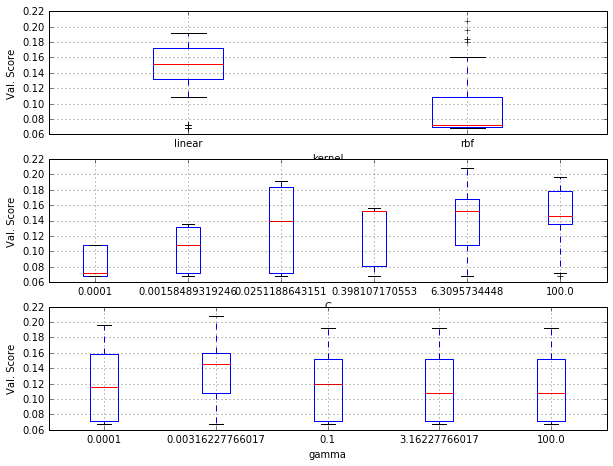

In [14]:
search.boxplot_parameters(display_train=False)

In [15]:
modfile='../models/'+model_keyword+'.pkl'
params=search.find_bests(1)[0][-1]
params

{'C': 100.0, 'gamma': 0.0001, 'kernel': 'rbf'}

In [16]:
#lb_view.abort()

In [17]:
def save_model(model,params,X_train,Y_train):
    model.set_params(**params)
    l=model.fit(X_train,Y_train)
    return l

In [18]:
mod=save_model(model,search.find_bests(1)[0][-1],X_train,Y_train)

In [19]:
from sklearn.externals import joblib
joblib.dump(mod,modfile)

['../models/bow_svm.pkl',
 '../models/bow_svm.pkl_01.npy',
 '../models/bow_svm.pkl_02.npy',
 '../models/bow_svm.pkl_03.npy',
 '../models/bow_svm.pkl_04.npy',
 '../models/bow_svm.pkl_05.npy',
 '../models/bow_svm.pkl_06.npy',
 '../models/bow_svm.pkl_07.npy',
 '../models/bow_svm.pkl_08.npy',
 '../models/bow_svm.pkl_09.npy',
 '../models/bow_svm.pkl_10.npy',
 '../models/bow_svm.pkl_11.npy']

In [20]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Y_pred=mod.predict(X_test)

In [21]:
from sklearn.metrics import accuracy_score
print 'Performance on Test set: %0.2f'% (accuracy_score(Y_test,Y_pred))

Performance on Test set: 0.04


Classification Statistics:
             precision    recall  f1-score   support

   airplane       0.00      0.00      0.00         6
 automobile       0.00      0.00      0.00        16
       bird       0.17      0.08      0.11        13
        cat       0.00      0.00      0.00        13
       deer       0.00      0.00      0.00        11
        dog       0.00      0.00      0.00         7
       frog       0.00      0.00      0.00         7
      horse       0.20      0.18      0.19        11
       ship       0.07      0.25      0.11         4
      truck       0.00      0.00      0.00        12

avg / total       0.05      0.04      0.04       100



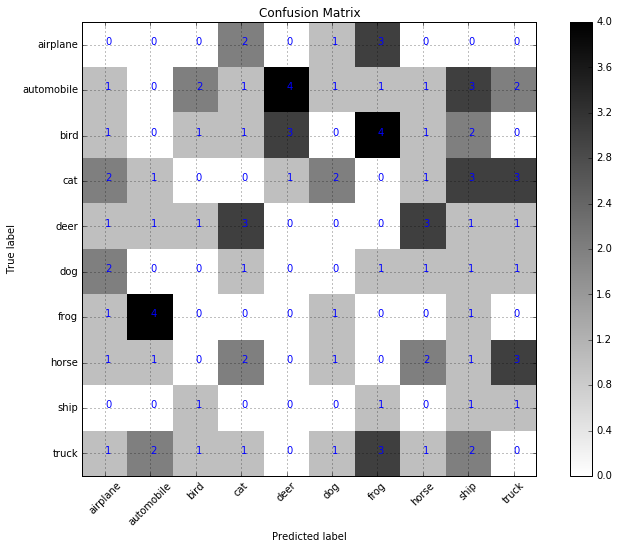

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print 'Classification Statistics:'
print classification_report(Y_test,Y_pred,target_names=classes)

conf = confusion_matrix(Y_test, Y_pred)
plt.imshow(conf, cmap='binary',interpolation='nearest')
plt.title('Confusion Matrix'); plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45);plt.yticks(tick_marks, classes)
plt.tight_layout();plt.ylabel('True label');plt.xlabel('Predicted label')
font = {'color':  'blue','stretch':'extra-expanded','weight':0,'size': 10}
for i,j in [(n,m) for n in range(len(classes)) for m in range(len(classes))]:
    plt.text(j,i,str(conf[i,j]),font)